In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [2]:
# Computes the station magnitudes
def compute_network_magnitude(station_magnitudes):
    return np.mean(station_magnitudes)

In [3]:
# Computes the feature matrix from a dataframe
def compute_feature_matrix(df, scaler = None):
    # Loosely speaking empirical magnitudes look like:
    # M = log10(A) + Q(Delta) 
    # where A is the amplitude and Q a distance dependent correction term.
    # Additionally, the difference between log10 and log amounts to a scalar
    # that a machine can learn.
    # Basically, I'm interested in features that:
    #   (1) Measure size in, potentially, different amplitudes.
    # different `passbands' deviates from the noise, 
    n_rows = len(df)
    n_columns = 33
    X = np.zeros([n_rows, n_columns])
    # Get a proxy on size
    
    # These are effectively amplitude ratios.  Note,
    # log(a/b) = log(a) - log(b)
    X[:,0]  = np.log(df['avg_signal_1.00']) - np.log(df['avg_noise_1.00'])
    X[:,1]  = np.log(df['avg_signal_2.00']) - np.log(df['avg_noise_2.00'])
    X[:,2]  = np.log(df['avg_signal_3.00']) - np.log(df['avg_noise_3.00'])
    X[:,3]  = np.log(df['avg_signal_4.00']) - np.log(df['avg_noise_4.00'])
    X[:,4]  = np.log(df['avg_signal_5.00']) - np.log(df['avg_noise_5.00'])
    X[:,5]  = np.log(df['avg_signal_6.00']) - np.log(df['avg_noise_6.00'])
    X[:,6]  = np.log(df['avg_signal_7.00']) - np.log(df['avg_noise_7.00'])
    X[:,7]  = np.log(df['avg_signal_8.00']) - np.log(df['avg_noise_8.00'])
    X[:,8]  = np.log(df['avg_signal_9.00']) - np.log(df['avg_noise_9.00'])
    X[:,9]  = np.log(df['avg_signal_10.00']) - np.log(df['avg_noise_10.00'])
    X[:,10] = np.log(df['avg_signal_11.00']) - np.log(df['avg_noise_11.00'])
    X[:,11] = np.log(df['avg_signal_12.00']) - np.log(df['avg_noise_12.00'])
    # Look at amplitudes
    X[:,12] = np.log(df['avg_signal_1.00']) 
    X[:,13] = np.log(df['avg_signal_2.00']) 
    X[:,14] = np.log(df['avg_signal_3.00']) 
    X[:,15] = np.log(df['avg_signal_4.00']) 
    X[:,16] = np.log(df['avg_signal_5.00'])
    X[:,17] = np.log(df['avg_signal_6.00'])
    X[:,18] = np.log(df['avg_signal_7.00'])
    X[:,19] = np.log(df['avg_signal_8.00'])
    X[:,20] = np.log(df['avg_signal_9.00'])
    X[:,21] = np.log(df['avg_signal_10.00'])
    X[:,22] = np.log(df['avg_signal_11.00'])
    X[:,23] = np.log(df['avg_signal_12.00'])
    # Frequency and max amplitude
    X[:,24] = np.log(df['signal_dominant_frequency'])
    X[:,25] = np.log(df['signal_dominant_amplitude'])
    # Time-based featuers: Look at max amplitudes of noise/signal
    X[:,26] = np.log(df['noise_maximum_value']  - df['noise_minimum_value'])
    X[:,27] = np.log(df['signal_maximum_value'] - df['signal_minimum_value'])
    X[:,28] = np.log(df['signal_variance'])
    X[:,29] = np.log(df['noise_variance'])
    # Source/recv distance (take log to flatten this)
    X[:,30] = np.log(df['source_receiver_distance_km'])
    X[:,31] = df['source_depth_km']
    # Single stations can learn location
    X[:,32] = df['source_receiver_back_azimuth']

    # Standardize features
    if (scaler is None):
        scaler = StandardScaler()
        scaler = scaler.fit(X)
    X = scaler.transform(X)
    return X, scaler
    
#X, scaler = compute_feature_matrix(df)

In [4]:
#print(X)

In [5]:
# Load the data frame
df_in = pd.read_csv('p_features.csv', dtype={'location_code': str})
print(df_in.columns)

Index(['avg_noise_1.00', 'avg_noise_10.00', 'avg_noise_11.00',
       'avg_noise_12.00', 'avg_noise_13.00', 'avg_noise_14.00',
       'avg_noise_15.00', 'avg_noise_16.00', 'avg_noise_17.00',
       'avg_noise_18.00', 'avg_noise_2.00', 'avg_noise_3.00', 'avg_noise_4.00',
       'avg_noise_5.00', 'avg_noise_6.00', 'avg_noise_7.00', 'avg_noise_8.00',
       'avg_noise_9.00', 'avg_signal_1.00', 'avg_signal_10.00',
       'avg_signal_11.00', 'avg_signal_12.00', 'avg_signal_13.00',
       'avg_signal_14.00', 'avg_signal_15.00', 'avg_signal_16.00',
       'avg_signal_17.00', 'avg_signal_18.00', 'avg_signal_2.00',
       'avg_signal_3.00', 'avg_signal_4.00', 'avg_signal_5.00',
       'avg_signal_6.00', 'avg_signal_7.00', 'avg_signal_8.00',
       'avg_signal_9.00', 'channel', 'event_identifier', 'location_code',
       'magnitude', 'magnitude_type', 'network', 'noise_dominant_amplitude',
       'noise_dominant_frequency', 'noise_maximum_value',
       'noise_minimum_value', 'noise_variance', '

Potential Features:

    1. avg_noise_1.00 : This is the average noise over the window preceding the P arrival with center frequency 1 Hz.
     .
     .
     .
    2. avg_noise_18.00 : This is the average noise over the window preceding the P arrival with center frequency 1 Hz.
    3. avg_signal_1.00 : This is the average signal over the window after (2.5 s?) the P arrival with center frequency 1 Hz.
     .
     .
     .
    4. avg_signal_18.00 : This is the average signal over the window after (2.5 s?) the P arrival with center frequency 18 Hz.
    5. network : The network code - e.g., UU or WY.
    6. station : The station code - e.g., YFT.
    7. channel : The channel code - e.g., EHZ.
    8. location_code : The location code -e.g., 01.
    9. noise_dominant_frequency : The dominant frequency of the noise in Hz in the prorcessing preceding the P arrival.
    10. noise_dominant_amplitude : The amplitude of the dominant frequency of the noise.
    11. noise_variance : The variance in the signal preceding the P arrival.  The variance is the signal energy - the signal DC energy.
    12. signal_variance : The variance in the signal following (2.5s?) the P arrival.
    13. source_receiver_distance_km : The source receiver distance in km.
    14. source_depth_km : The source depth in km.
    15. source_latitude : The source latitude in degrees.
    16. source_longitude : The source longitude in degrees.
    17. event_identifier : The event identifier to help with splitting data.
    18. source_receiver_back_azimuth : This is the receiver to source azimuth in degrees.  Effectively, with this, the source-receiver distance an ML model can learn a source-location dependent source model.  Alternatively, you can use source_latitude and source_longitude.  But both seems pretty redundant and probably not a great idea.
    
Potential Targets:

    1. magnitude_type : The magnitude type.  We should regress against one target type.
    2. magnitude : The event magnitude.  This is the target.

In [6]:
# Ensure we use 1 magnitude type
df = df_in[ df_in.magnitude_type == 'l']

In [7]:
# Make sure variances are sensible
#df = df[df.signal_variance < 10]
#df = df[df.noise_variance < 10]
#df = df[df.signal_variance > df.noise_variance]

In [8]:
# Get unique stations
stations = df.network.values + '.' + df.station.values
print(np.unique(stations))

['GS.ID08' 'IE.ECRI' 'IE.GRRI' 'IE.HHAI' 'IE.PTI' 'MB.BGMT' 'MB.BZMT'
 'MB.CRMT' 'MB.MOMT' 'MB.QLMT' 'MB.TPMT' 'PB.B206' 'PB.B207' 'PB.B208'
 'PB.B944' 'PB.B945' 'PB.B950' 'WY.MCID' 'WY.YDC' 'WY.YDD' 'WY.YEE'
 'WY.YFT' 'WY.YGC' 'WY.YHB' 'WY.YHH' 'WY.YHL' 'WY.YHR' 'WY.YJC' 'WY.YLA'
 'WY.YLT' 'WY.YMC' 'WY.YML' 'WY.YMP' 'WY.YMR' 'WY.YMS' 'WY.YMV' 'WY.YNE'
 'WY.YNM' 'WY.YNR' 'WY.YPC' 'WY.YPK' 'WY.YPM' 'WY.YPP' 'WY.YSB' 'WY.YTP'
 'WY.YUF' 'WY.YWB']


In [9]:
df = df_in[ (df_in.network == 'WY') & (df_in.station == 'YNR') & (df_in.magnitude_type == 'l')]

In [10]:
# Create some features
#df['d_variance'] = df.signal_variance - df.noise_variance
#df['log10_d_variance'] = np.log10(df['d_variance'])
#df['log10_d_signal_4'] = np.log10(df['avg_signal_4.00'])

In [11]:
# Split on evids
evids = np.unique(df.event_identifier)
train_evids, test_evids = train_test_split(evids, test_size = 0.2, random_state = 843823)

In [12]:
keep_train = np.zeros(len(df), dtype='bool')
keep_test  = np.zeros(len(df), dtype='bool')
evids = df.event_identifier.values
for i in range(len(evids)):
    keep_train[i] = evids[i] in train_evids
    keep_test[i]  = ~keep_train[i]
df_train = df[keep_train]
df_test  = df[keep_test]

assert len(df_train) + len(df_test) == len(df), 'missed some'
print("Number of training examples", len(df_train))
print("Number of testing examples", len(df_test))

Number of training examples 4013
Number of testing examples 1004


In [13]:
[X_train, scaler] = compute_feature_matrix(df_train)
y_train = df_train.magnitude.to_numpy()
[X_test, bogus] = compute_feature_matrix(df_test, scaler)
y_test = df_test.magnitude.to_numpy()

In [14]:
svr = SVR(C=1.0, epsilon=0.2)
svr.fit(X_train, y_train)

SVR(epsilon=0.2)

In [15]:
y_est = svr.predict(X_test)
print("Test MSE:", mean_squared_error(y_test, y_est))
print("Test R2:", r2_score(y_test, y_est))

Test MSE: 0.04292057606493033
Test R2: 0.8582599314412247


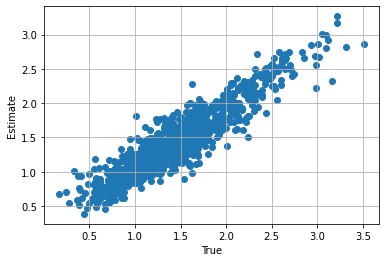

In [16]:
plt.scatter(y_test, y_est)
plt.grid(True)
plt.xlabel("True")
plt.ylabel("Estimate")
plt.show()

Test MSE: 0.08009312190519827
Test R2: 0.7352284635488977


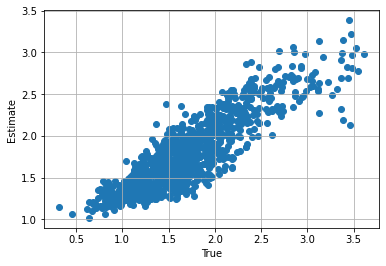

In [19]:
# For kicks let's try another station (the model shouldn't be that transportable) but YNM is close to YNR
df_ynm = df_in[ (df_in.network == 'WY') & (df_in.station == 'YNM') & (df_in.magnitude_type == 'l')]
[X_test_ynm, bogus] = compute_feature_matrix(df_ynm, scaler)
y_test_ynm = df_ynm.magnitude.to_numpy()
y_est_ynm = svr.predict(X_test_ynm)
print("Test MSE:", mean_squared_error(y_test_ynm, y_est_ynm))
print("Test R2:", r2_score(y_test_ynm, y_est_ynm))

plt.scatter(y_test_ynm, y_est_ynm)
plt.grid(True)
plt.xlabel("True")
plt.ylabel("Estimate")
plt.show()

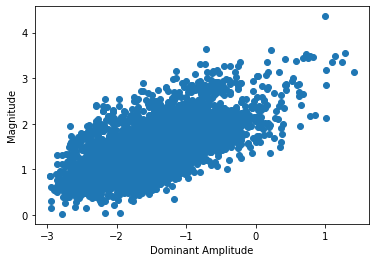

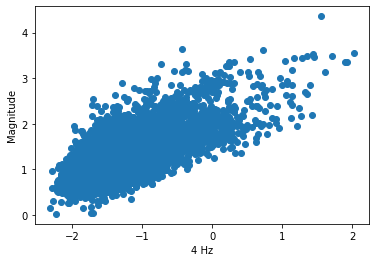

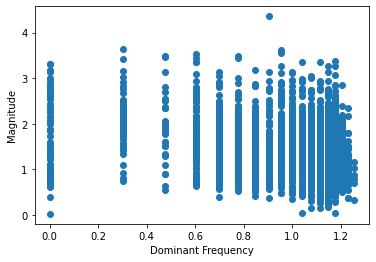

In [18]:
#plt.scatter(df_train['d_variance'], df_train['magnitude'])
mask = (df_train['source_receiver_distance_km'] > 0) & (df_train['source_receiver_distance_km'] < 50)
#plt.scatter(np.log10(df_train['d_variance'][mask]), df_train['magnitude'][mask])
#plt.ylabel("Magnitude")
#plt.xlabel("Variance")
#plt.show()
#df_train.describe()['signal_variance']

plt.scatter(np.log10(df_train['signal_dominant_amplitude'][mask]), df_train['magnitude'][mask])
plt.ylabel("Magnitude")
plt.xlabel("Dominant Amplitude")
plt.show()

plt.scatter(np.log10(df_train['avg_signal_4.00'][mask]), df_train['magnitude'][mask])
plt.ylabel("Magnitude")
plt.xlabel("4 Hz")
plt.show()

plt.scatter(np.log10(df_train['signal_dominant_frequency'][mask]), df_train['magnitude'][mask])
plt.ylabel("Magnitude")
plt.xlabel("Dominant Frequency")
plt.show()